# **PROJ003** | **AI Agent Graph** [_from scratch_]
### Data & Analytics 
#### AI Integration and architecture
#### **Python routine** - jupyter-notebook

> *LANGGRAPH* // *LANHCHAIN* // *OPENROUTER*


###### code designed by a human on Earth    `Guilherme Ribeiro Zucco`

In [30]:
# Libs & packages imports
import feedparser
import numpy as np
import pandas as pd
import yfinance as yf
import os, sys, pathlib
import requests, json, operator
import logging, warnings
import datetime, time 
from operator import add
from typing import Optional, Literal, Annotated, List, Any, NamedTuple
from typing_extensions import TypedDict
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from pydantic import Field, SecretStr
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor
from langgraph.prebuilt import ToolNode, tools_condition

load_dotenv()

class State(TypedDict):
    messages: Annotated[list, add_messages]

class AnnotatedState(TypedDict):
    """
    Represents the state of our application.

    Attributes:
        messages (Annotated[List[BaseMessage], operator.add]):
            A list of messages where new messages are added using `operator.add`.
        context (str):
            A string for additional context.
    """
    messages: Annotated[List[BaseMessage], operator.add]
    context: str

class WeatherState(TypedDict):
    """Represents the state of our graph."""
    city_name: str
    latitude: str
    longitude: str
    messages: Annotated[list[BaseMessage], add]

In [31]:
# Credentials setup
credentials = {
    'open_router-secret' : SecretStr(os.environ.get('OPENROUTER_API_KEY')),
    'google-LLM_model' : os.environ.get('GOOGLE_MODEL_ID'),
    'claude-LLM_model' : os.environ.get('CLAUDE_MODEL_ID'),
    'amazon-LLM_model' : os.environ.get('AMAZON_MODEL_ID'),
    'horizon-LLM_model' : os.environ.get('HORIZON_MODEL_ID'),
    'openai-LLM_model' : os.environ.get('OPENAI_MODEL_ID'),
    'open_router_base_url' : os.environ.get('OPENROUTER_BASE_URL') 
               }

# Default temperature for LLMs
modelTemperature = {
    'google-LLM_model': 0.25,
    'claude-LLM_model': 0.30,
    'amazon-LLM_model': 0.50,
    'horizon-LLM_model': 0.20,
    'openai-LLM_model' : 0.15
}

print("Current dir:", f'{pathlib.Path(os.path.abspath(os.curdir))} - {os.uname()}')
print("Available credentials:" + str(credentials.values()))
print("Available model temperatures:" + str(modelTemperature.values()))

Current dir: /Users/guilhermezucco/Documents/GitHub/LangGraph - posix.uname_result(sysname='Darwin', nodename='Guilhermes-MacBook-Air.local', release='24.6.0', version='Darwin Kernel Version 24.6.0: Mon Jul 14 11:28:17 PDT 2025; root:xnu-11417.140.69~1/RELEASE_X86_64', machine='x86_64')
Available credentials:dict_values([SecretStr('**********'), 'google/gemini-2.0-flash-lite-001', 'anthropic/claude-3.5-haiku', 'amazon/nova-micro-v1', 'openrouter/horizon-beta', 'openai/gpt-4.1-nano', 'https://openrouter.ai/api/v1'])
Available model temperatures:dict_values([0.25, 0.3, 0.5, 0.2, 0.15])


In [32]:
# Environ variables for credentials
for (idx,i) in enumerate(credentials.keys(),start=1):
    print(f'Key {idx}: {i} - ', credentials[i])

# Available models in OpenRouter
def get_models():
    """Fetch available models from OpenRouter API."""
    url = "https://openrouter.ai/api/v1/models"
    response = requests.get(url)
    return response.json()
get_models()

Key 1: open_router-secret -  **********
Key 2: google-LLM_model -  google/gemini-2.0-flash-lite-001
Key 3: claude-LLM_model -  anthropic/claude-3.5-haiku
Key 4: amazon-LLM_model -  amazon/nova-micro-v1
Key 5: horizon-LLM_model -  openrouter/horizon-beta
Key 6: openai-LLM_model -  openai/gpt-4.1-nano
Key 7: open_router_base_url -  https://openrouter.ai/api/v1


{'data': [{'id': 'qwen/qwen3-coder-flash',
   'canonical_slug': 'qwen/qwen3-coder-flash',
   'hugging_face_id': '',
   'name': 'Qwen: Qwen3 Coder Flash',
   'created': 1758115536,
   'description': "Qwen3 Coder Flash is Alibaba's fast and cost efficient version of their proprietary Qwen3 Coder Plus. It is a powerful coding agent model specializing in autonomous programming via tool calling and environment interaction, combining coding proficiency with versatile general-purpose abilities.",
   'context_length': 128000,
   'architecture': {'modality': 'text->text',
    'input_modalities': ['text'],
    'output_modalities': ['text'],
    'tokenizer': 'Qwen3',
    'instruct_type': None},
   'pricing': {'prompt': '0.0000003',
    'completion': '0.0000015',
    'request': '0',
    'image': '0',
    'web_search': '0',
    'internal_reasoning': '0',
    'input_cache_read': '0.00000008'},
   'top_provider': {'context_length': 128000,
    'max_completion_tokens': 65536,
    'is_moderated': False

In [33]:
# Artifacts and decorated functions as tools

# Function to create model instance with context in OpenRouter
def create_model_with_context(fixed_context: str, model):
    """
    Creates a LangChain LLM with a system prompt that includes a fixed context.
    """
    system_prompt = ("system", fixed_context)
    prompt = ChatPromptTemplate.from_messages([
        system_prompt,
        ("human", "{input}")
    ])
    return prompt | model

# Function to check the user request and decide the next step
def check_user_request(state: State) -> Literal['weather','news', 'end']:
    if state['messages'][-1].content.split(':')[0]=='weather':
        return 'weather'
    if state['messages'][-1].content.split(':')[0]=='news':
        return 'news'
    if state['messages'][-1].content.split(':')[0]=='finance':
        return 'finance'
    else:
        return 'end'
    
# Function as a tool to get city weather information
@tool
def get_cityInfo(input: WeatherState) -> str:
    '''
    When the question is about weather, this function should always be called - no exceptions.
    The function fetches the current temperature and wind speed for the specified city using the Open-Meteo API.
    Return: 
        In your return, you don't have to send the latitude and longitude ahead (to neither user nor another AI).
        Your response must be verbose. Don't be shy! 
        Keep it simple, but tell the user about the current weather and if it's always like that or not
        Don't chop the emogis, also use them a lot!
    '''
    latitude=str(input.get('latitude'))
    longitude=str(input.get('longitude'))
    city_name=input.get('city_name')
    
    api_url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"

    try: 
        response = requests.get(api_url)
        data = response.json()
        temperature = data['current_weather']['temperature']
        wind_speed = data['current_weather']['windspeed']

        return {
            'info':(latitude,longitude),
            'message':f'Weather in {city_name}: The current Temperature 🌡️ now is {temperature}°C; The average wind speed across the city is 💨 {wind_speed} km/h'
            }
    except:
        return {
            'info':(0,0), 
            'message':'The api is not responding. Please, try again!'}

# Function as a tool to get news information
@tool
def get_rssFeed(news_type:Literal['news:world', 'news:brazil'])->str:
    '''
    This function acts as a tool to retrieve news information from a given URL.
    It should take a Literal string as input and pass it into a dictionary to get the corresponding URL.
    Return:
        This tool is expected to return a dictionary with news information, regarding:
        - Site's title and link
        - ID keys with a nested dictionary with several news info
    '''
    urls={
        'news:world': r'https://g1.globo.com/dynamo/mundo/rss2.xml',
        'news:brazil':r'https://g1.globo.com/dynamo/brasil/rss2.xml'
        }

    news=dict()
    feed = feedparser.parse(urls[news_type])

    if hasattr(feed.feed,'link'): news['source']=feed.feed.link
    if hasattr(feed.feed,'title'): news['page_title']=feed.feed.title

    if hasattr(feed,'entries'):
        news['news']={}
        for (index, entry) in enumerate(feed.entries[0:10], start=1):
            news['news'][f'id_{index}']={}
            if hasattr(entry,'title'): news['news'][f'id_{index}']['title']=entry.title
            if hasattr(entry,'subtitle'): news['news'][f'id_{index}']['subtitle']=entry.subtitle
            if hasattr(entry,'summary'): news['news'][f'id_{index}']['description']=entry.summary
    return news

# Function as a tool to get stock
@tool
def get_stockPrice(ticker:str):
    ''' 
    This function should be used as a tool when the user asks about a company's stock price, or similar.
    Thus, it takes the corresponding ticker found for the given company and returns a dictionary-like response.
    The response regards values for the last day found, which means it is the most recent info.
    Args:
        String with ticker value for found company
    Return:
        It should be a dictionary with keys that hold values for 'Open', 'Close' etc.
        The timestamps regard the information date.
    For cases that the company has no data, but has a ticker, tell the user! 
    '''
    try:
        return yf.Ticker(ticker).history('1d').to_dict()
    except:
        return 'No info because there is no data or the company was unlisted!'


In [34]:
# Context dictionary
context = {
    'agent-context': """ You are a helpful assistant that provides information based on user queries.

    # If the user asks about weather or requests location-based information, always call the appropriate tool with the city name, latitude, and longitude.
        If the question made by the user refers to the weather of a specific city, you should return the value 'weather:city name'. 
    
    # If the user asks about news, you may answer the question with tools.
        Dedending on the question about news, follow up accordingly with these two answers:
            - if the question is about the world, or doesn't mention a location, or mentions any location other than Brazil, always answer: 'news:world'
            - if the question mentions Brazil, or any other location in brazil, always answer: 'news:brazil'
    
    # If the user asks about a financial value or stock value for a given company, you must:
        - First, find out the company's ticker name listed in the stock market.
        - Then, return a string that contains the ticker, which is expected to be an uppercaser 3-to-5-letter word. 
        The answer must be as follows: 'finance:<ticker>'. 
        If the question at hand is about finance in general, but doesn't mention stock prices or related topics,return 'empty'
    
    #In any other case, you must return the value string 'empty'. 
    
    Examples: 
     1. User: 'What is the weather in New York?'
     AI response: 'weather:New York'.

     2. User: What's going on in the world?
     AI response: 'news:world'

     3. User: What's going happening in Brazil?
     AI response: 'news:brazil'

     4. User: What's life?
     AI response: empty
    
    5. User: What's the current value for the Apple company?
    AI response: 'finance:AAPL'
    """,
    'geo-location': """ If you receive a request about a city in a way that is similar to this: 'wheater':city_name, 
    you should only return the latitude and longitude of that city in the format 'weather:city_name:latitude=int,longitude=int'. 
    For example, if the user asks for the location of 'New York', you should return 'weather:New York:latitude=40.7128,longitude=-74.0060'. 
    Do not provide any additional information or context. In case the users does not specify a city, you should return 'empty' 
    as the default location.
    """,
    'news-broadcaster': """ You are a news broadcaster that uses the tool to get RSS information and receives a dictionary with several news.
    Your job is to deliver the news, preferably printed in a nice way.
    DON'T CHOP THE INFO IN YOUR OUTPUT TO THE USER! I need you to be verbose in your final answer! 
    Don't be shy to give an answer that contains most of the news collected in your tools.
    """,
    'finance-bro': """ You're a stock exchange analist that delivers short and concise information about a given company's stock values.
    You must respond with informations regarding the stock close and open values, its volume and so on.
    To retrieve current informations, you may use the tool that is appropriated for said task.
    Your response, if possible, should return also the date when this information was gathered.
    For cases in which the company is listed but no data was retreived, inform the user the tiker and that it was not possible to complete the task.
    As argument, you need to pass to the tool the stock ticker for the company found on query.
    """,
    'master-of-none': """ You are a generalist assistant that can handle a wide range of topics and tasks.
    If the user's query does not fit into specific categories like weather, news, or finance, you should respond to the query directly without using any tools.
    It should be a concise and informative answer, tailored to the user's needs. However, try not to extend too much and keep it simple. Be a little evasive.
    """
    }

In [35]:
# Initialize LLMs with OpenRouter
# Using ChatOpenAI from langchain_openai with OpenRouter credentials

# Google's Gemini-Flash LLM
llmGoogle = ChatOpenAI(
  api_key=credentials['open_router-secret'],
  base_url=credentials['open_router_base_url'],
  model=credentials['google-LLM_model'],
  temperature=modelTemperature.get('google-LLM_model'),
  max_retries=3,
  max_tokens=None,
  request_timeout=60,
  verbose=True
)

# Anthropic's Claude-Sonnet LLM
llmClaude = ChatOpenAI(
  api_key=credentials['open_router-secret'],
  base_url=credentials['open_router_base_url'],
  model=credentials['claude-LLM_model'],
  temperature=modelTemperature.get('claude-LLM_model'),
  max_retries=3,
  max_tokens=None,
  request_timeout=60,
  verbose=True
)

# Amazon's Nova LLM
llmNova = ChatOpenAI(
  api_key=credentials['open_router-secret'],
  base_url=credentials['open_router_base_url'],
  model=credentials['amazon-LLM_model'],
  temperature=modelTemperature.get('amazon-LLM_model'),
  max_retries=3,
  max_tokens=None,
  request_timeout=60,
  verbose=True
)

# Openrouter's Free Horizon LLM
llmHorizon = ChatOpenAI(
  api_key=credentials['open_router-secret'],
  base_url=credentials['open_router_base_url'],
  model=credentials['horizon-LLM_model'],
  temperature=modelTemperature.get('horizon-LLM_model'),
  max_retries=3,
  max_tokens=None,
  request_timeout=60,
  verbose=True
)

# OpenAI's ChatGPT
llmOpenAI = ChatOpenAI(
  api_key=credentials['open_router-secret'],
  base_url=credentials['open_router_base_url'],
  model=credentials['openai-LLM_model'],
  temperature=modelTemperature.get('openai-LLM_model'),
  max_retries=3,
  max_tokens=None,
  request_timeout=60,
  verbose=True
)

# Display model names
print(f"LLM Google Gemini model: {llmGoogle.model_name}")
print(f"LLM Anthropic Claude model: {llmClaude.model_name}")
print(f"LLM AWS Bedrock Nova model: {llmNova.model_name}")
print(f"LLM OpenRouter Horizon model: {llmHorizon.model_name}")
print(f"LLM OpenAI Chat-GPT model: {llmOpenAI.model_name}")

LLM Google Gemini model: google/gemini-2.0-flash-lite-001
LLM Anthropic Claude model: anthropic/claude-3.5-haiku
LLM AWS Bedrock Nova model: amazon/nova-micro-v1
LLM OpenRouter Horizon model: openrouter/horizon-beta
LLM OpenAI Chat-GPT model: openai/gpt-4.1-nano


Graph visual model: 



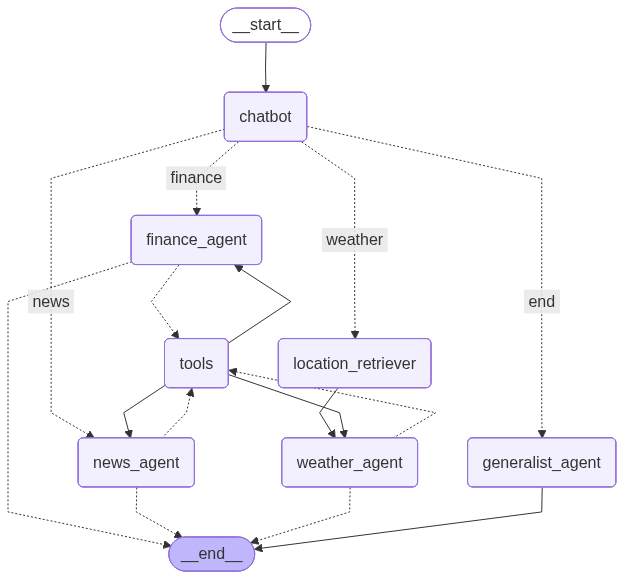

In [39]:
# Toolbox
tools = [get_cityInfo, get_rssFeed, get_stockPrice]

# Building the chatbots instances for LangGraph
def chatbot(state: State):
    agent = create_model_with_context(
        fixed_context=context['agent-context'], 
        model=llmGoogle
    ); return {"messages":[agent.invoke(state["messages"])]}

# Chatbot for location retrieving
def chatbot_location(state: State):
    location_retriever = create_model_with_context(
        fixed_context=context['geo-location'], 
        model=llmGoogle)
    return {"messages":[location_retriever.invoke(state["messages"])]}

# Chatbot for weather response
llm_with_tools_weather = llmClaude.bind_tools([get_cityInfo])
def chatbot_llm_with_tools_weather(state: State):
    return {"messages":[llm_with_tools_weather.invoke(state["messages"])]}

# Chatbot for news response
llm_with_tools_news = llmNova.bind_tools([get_rssFeed])
def chatbot_llm_with_tools_news(state: State):
    agent = create_model_with_context(
        fixed_context=context['news-broadcaster'],
        model=llm_with_tools_news
    ); return {"messages":[agent.invoke(state["messages"])]}

# Chatbot for financial stock value
llm_with_tools_finance = llmGoogle.bind_tools([get_stockPrice])
def chatbot_llm_with_tools_finance(state: State):
    agent = create_model_with_context(
        fixed_context=context['finance-bro'],
        model=llm_with_tools_finance
    ); return {"messages":[agent.invoke(state["messages"])]}

# Generalist model for other tasks
def chatbot_generalist(state: State):
    agent = create_model_with_context(
        fixed_context=context['master-of-none'],
        model=llmOpenAI
    ); return {"messages":[agent.invoke(state["messages"])]}

# Building the state graph
builder = StateGraph(State)

builder.add_node('chatbot',chatbot)
builder.add_node("tools", ToolNode(tools))
builder.add_node('location_retriever',chatbot_location)
builder.add_node('weather_agent',chatbot_llm_with_tools_weather)
builder.add_node('news_agent',chatbot_llm_with_tools_news)
builder.add_node('finance_agent',chatbot_llm_with_tools_finance)
builder.add_node('generalist_agent',chatbot_generalist)

builder.add_edge(START, 'chatbot')
builder.add_conditional_edges(
    'chatbot',
    check_user_request,
    {
        'end': 'generalist_agent',
        'weather': 'location_retriever',
        'news': 'news_agent',
        'finance': 'finance_agent'
    }
)

builder.add_edge('location_retriever', 'weather_agent')
builder.add_edge('tools', 'weather_agent')

builder.add_conditional_edges('weather_agent', tools_condition)
builder.add_edge('weather_agent', END)

builder.add_conditional_edges('news_agent', tools_condition)
builder.add_edge('tools', 'news_agent')
builder.add_edge('news_agent', END)

builder.add_conditional_edges('finance_agent', tools_condition)
builder.add_edge('tools', 'finance_agent')
builder.add_edge('finance_agent', END)

graph = builder.compile()

print('Graph visual model:','\n')
display(Image(graph.get_graph().draw_mermaid_png()))


In [40]:
# Query from user
query=input(prompt='Please, user, ask a question!')
state = graph.invoke({"messages": [{"role": "user", "content": query}]})

# Model interactions
print('Model interactions:')
for (i, j) in enumerate(state['messages'][0:-1],start=1):
    print(i, j)

Model interactions:
1 content="what's going on in the world right now?" additional_kwargs={} response_metadata={} id='2778c6ee-01c4-4844-8eaf-408079ad52d6'
2 content='news:world\n' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 494, 'total_tokens': 498, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'google/gemini-2.0-flash-lite-001', 'system_fingerprint': None, 'id': 'gen-1758143068-5S0ILBf15Vfw00eaTH7S', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--7a46cfca-d390-4440-80ec-e2acfac15e8b-0' usage_metadata={'input_tokens': 494, 'output_tokens': 4, 'total_tokens': 498, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}
3 content='<thinking> The user is asking for 

In [41]:
# Final results from model

# # Result
# print('Regular Claude response:')
# print(llmClaude.invoke(query),'\n\n')

# # Result
# print('Regular Google response:')
# print(llmGoogle.invoke(query),'\n\n')

# Result
print('\n','Model response:')
print(state["messages"][-1].content,'\n\n')


 Model response:
Based on the latest world news from the RSS feed, here are some key highlights:

1. US-Venezuela Tensions:
- Donald Trump claims the US military has eliminated three Venezuelan vessels in the Caribbean, alleging they were involved in drug trafficking.
- Venezuela's President Nicolás Maduro has called this a potential "war in the Caribbean" and is mobilizing military forces in response.
- The UN Human Rights Council has criticized these actions, stating that criminal activities should be investigated through legal processes.

2. US Political Developments:
- The Federal Reserve (Fed) has reduced interest rates for the first time in 9 months, cutting them by 0.25 percentage points.
- There are ongoing tensions between Trump and the Fed, with Trump attempting to influence the institution's leadership.

3. Brazil-US Relations:
- Tensions continue between the US and Brazil, particularly regarding the Supreme Court's decision to convict former President Jair Bolsonaro.
- US 